# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [52]:
%pip install pandas-datareader
%pip install git+https://github.com/elben10/pydst
%pip install matplotlib-venn

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
from scipy.stats.mstats import gmean

import pandas_datareader 
import pydst 

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# user written modules
import dataproject

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/elben10/pydst to /private/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/pip-req-build-4_ninlbk
  Running command git clone --filter=blob:none --quiet https://github.com/elben10/pydst /private/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/pip-req-build-4_ninlbk
  Resolved https://github.com/elben10/pydst to commit bb347560a1b3c17684fda072c829658da38f5a72
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Import your data, either through an API or manually, and load it. 

Flats

In [53]:
# Loading the Data from statistikbanken
filename1 = 'Ejerlejligheder.xlsx'
pd.read_excel(filename1).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),"Ejerlejligheder, i alt",Hele landet,421.0,419.0,452.0,474.0,514.0,536.0,...,1845.0,1945.0,2063.0,2156.0,2369.0,2470.0,2570.0,2800.0,3005.0,2847.0
3,NaN,NaN,NaN,Region Hovedstaden,446.0,443.0,482.0,502.0,538.0,557.0,...,2166.0,2236.0,2351.0,2511.0,2813.0,2958.0,3066.0,3351.0,3664.0,3520.0
4,NaN,NaN,NaN,Landsdel Byen København,421.0,417.0,453.0,475.0,510.0,529.0,...,2341.0,2411.0,2570.0,2798.0,3182.0,3355.0,3449.0,3730.0,4174.0,4026.0


In [54]:
# Now we are dropping rows
ap = pd.read_excel(filename1, skiprows=2)

# Now we drop the first three columns
del ap['Unnamed: 0'], ap['Unnamed: 1'], ap['Unnamed: 2']

# Now we rename the variable 'Unnamed: 3' 
ap.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'ap{i}' 
ap.rename(columns = col_dict, inplace=True)

# We are only interesetd in the Countys so we drop the regions and the whole country
I = ap.County.str.contains('Region')
I |= ap.County.str.contains('Hele landet')
ap.loc[I, :]
ap = ap.loc[I == False]

# We reset the index 
ap.reset_index(inplace = True, drop = True) # Drop old index too
ap.iloc[0:5,:]

ap_long = pd.wide_to_long(ap, stubnames='ap', i='County', j='year')
ap_long.head(11)

,,ap
County,year,
Landsdel Byen København,1992,421
Landsdel Københavns omegn,1992,474
Landsdel Nordsjælland,1992,504
Landsdel Bornholm,1992,377
Landsdel Østsjælland,1992,466
Landsdel Vest- og Sydsjælland,1992,338
Landsdel Fyn,1992,338
Landsdel Sydjylland,1992,374
Landsdel Østjylland,1992,434


Houses

In [55]:
# Loading the Data from statistikbanken
filename2 = 'Familiehuse.xlsx'
pd.read_excel(filename2).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),Enfamiliehuse,Hele landet,551.0,565.0,622.0,656.0,753.0,806.0,...,1883.0,1955.0,2082.0,2122.0,2209.0,2257.0,2335.0,2477.0,2639.0,2464.0
3,NaN,NaN,NaN,Region Hovedstaden,777.0,789.0,876.0,935.0,1088.0,1195.0,...,2965.0,3075.0,3310.0,3465.0,3623.0,3754.0,3873.0,4231.0,4723.0,4471.0
4,NaN,NaN,NaN,Landsdel Byen København,767.0,785.0,856.0,917.0,1063.0,1169.0,...,3535.0,3775.0,4129.0,4441.0,4725.0,4938.0,5128.0,5708.0,6198.0,6146.0


In [56]:
# Now we are dropping rows
house = pd.read_excel(filename2, skiprows=2)

# Now we drop the first three columns
del house['Unnamed: 0'], house['Unnamed: 1'], house['Unnamed: 2']

# Now we rename the variable 'Unnamed: 3' 
house.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'house{i}' 
house.rename(columns = col_dict, inplace=True)

# We are only interesetd in the Countys so we drop the regions and the whole country
J = house.County.str.contains('Region')
J |= house.County.str.contains('Hele landet')
house.loc[I, :]
house = house.loc[I == False]

# We reset the index 
house.reset_index(inplace = True, drop = True) # Drop old index too
house.iloc[0:5,:]

house_long = pd.wide_to_long(house, stubnames='house', i='County', j='year')
house_long.head(11)

,,house
County,year,
Landsdel Byen København,1992,767
Landsdel Københavns omegn,1992,836
Landsdel Nordsjælland,1992,797
Landsdel Bornholm,1992,335
Landsdel Østsjælland,1992,704
Landsdel Vest- og Sydsjælland,1992,445
Landsdel Fyn,1992,470
Landsdel Sydjylland,1992,494
Landsdel Østjylland,1992,557


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

<AxesSubplot:xlabel='year'>

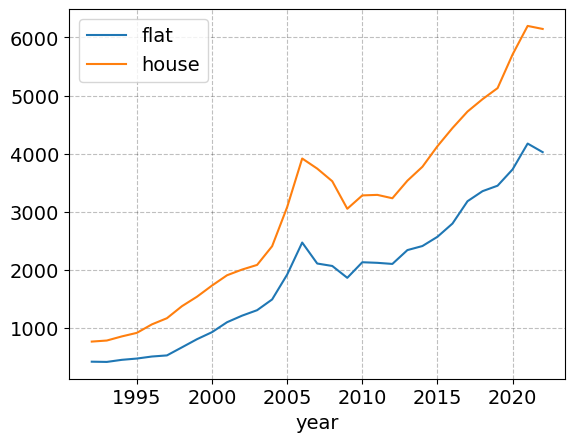

In [57]:
# Data with København Flats
ap_long_2 = ap_long.reset_index()
ap_long_2.loc[ap_long_2.County == 'Landsdel Byen København', :] 
ap_københavn = ap_long_2.loc[ap_long_2['County'] == 'Landsdel Byen København', :]

# Data with København Houses
house_long_2 = house_long.reset_index()
house_long_2.loc[house_long_2.County == 'Landsdel Byen København', :]
house_københavn = house_long_2.loc[house_long_2['County'] == 'Landsdel Byen København', :]

# Plotting
ax = ap_københavn.plot(x='year', y='ap', label = 'flat')
house_københavn.plot(x='year', y='house', ax=ax)


**Interactive plot** :

In [87]:
def plot_func(df, County):
    # Function that operates on data set
    I = df['County'] == County
    ax=df.loc[I,:].plot(x='year', y='house', style='-o', legend=False)

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
    df = widgets.fixed(house_long_2),
    County = widgets.Dropdown(description='County', 
                                    options=house_long_2.County.unique(), 
                                    value='Landsdel Byen København')
);


interactive(children=(Dropdown(description='County', options=('Landsdel Byen København', 'Landsdel Københavns …

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

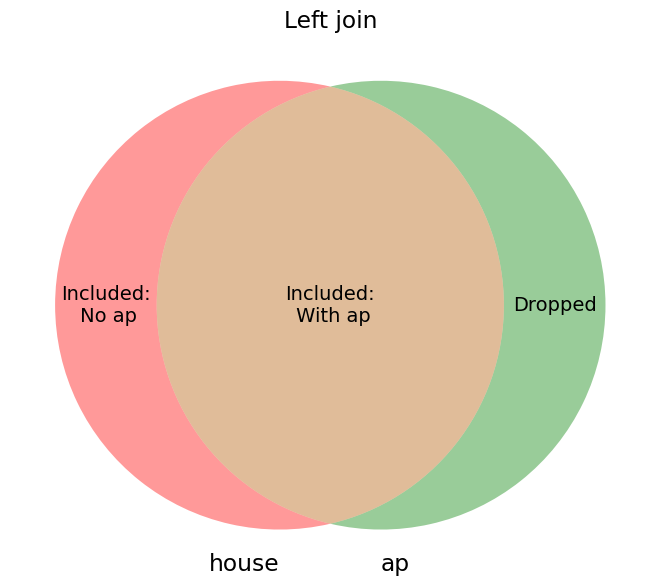

In [59]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('house', 'ap'))
v.get_label_by_id('100').set_text('Included:\n No ap')
v.get_label_by_id('010').set_text('Dropped' )
v.get_label_by_id('110').set_text('Included:\n With ap')
plt.title('Left join')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

In [60]:
# We make a left join merge 
join = pd.merge(house, ap, on='County', how='left')
join.head(10)


,County,house1992,house1993,house1994,house1995,house1996,house1997,house1998,house1999,house2000,...,ap2013,ap2014,ap2015,ap2016,ap2017,ap2018,ap2019,ap2020,ap2021,ap2022
0,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
1,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
2,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439
3,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,607,679,700,875,898,657,809,895,1274,948
4,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,1406,1387,1582,1723,1787,1938,2093,2302,2495,2383
5,Landsdel Vest- og Sydsjælland,445,457,490,517,567,616,675,732,795,...,906,958,999,1058,1076,1087,1133,1179,1268,1259
6,Landsdel Fyn,470,477,523,555,639,686,785,816,860,...,1149,1198,1354,1340,1438,1585,1651,1750,1757,1770
7,Landsdel Sydjylland,494,508,559,583,664,704,754,810,852,...,1089,1083,1191,1177,1231,1366,1450,1407,1546,1506
8,Landsdel Østjylland,557,564,626,662,774,820,910,971,1035,...,1582,1690,1791,1825,1973,2017,2145,2272,2476,2363
9,Landsdel Vestjylland,471,483,530,558,617,646,699,737,767,...,1069,1017,1065,1047,1127,1152,1168,1137,1259,1221


In [61]:
join_long = join.melt(id_vars=['County'], var_name = 'Year', value_name='Price')
join_long['Type'] = join_long['Year'].str[:-4]
join_long['Year'] = join_long['Year'].str[-4:]
join_long['County'] = join_long['County'].str.slice(start=9)
join_long.sort_values(['Year', 'County'], ignore_index=True)

,County,Year,Price,Type
0,Bornholm,1992,335,house
1,Bornholm,1992,377,ap
2,Byen København,1992,767,house
3,Byen København,1992,421,ap
4,Fyn,1992,470,house
...,...,...,...,...
677,Vestjylland,2022,1221,ap
678,Østjylland,2022,2655,house
679,Østjylland,2022,2363,ap
680,Østsjælland,2022,3684,house


# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

In [83]:
# We calculate the growthrate and the geometric mean in houseprices in copenhagen 
house_københavn['Growth_Rate'] = (house_københavn['house'].pct_change(periods=1) * 100)
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())
gm1 = g_mean(house_københavn2['Growth_Rate'])
print ("%.2f" % gm1)
house_københavn['Gmean'] = gm1
house_københavn['D_Gmean'] = house_københavn.Growth_Rate - house_københavn.Gmean
house_københavn.head(10)

7.72


/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/ipykernel_24807/865904773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_københavn['Growth_Rate'] = (house_københavn['house'].pct_change(periods=1) * 100)
/Users/joakimhagerupjensen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/ipykernel_24807/865904773.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

,County,year,house,Growth_Rate,Gmean,D_Gmean
0,Landsdel Byen København,1992,767,NaN,7.718157,NaN
11,Landsdel Byen København,1993,785,2.346806,7.718157,-5.371351
22,Landsdel Byen København,1994,856,9.044586,7.718157,1.326429
33,Landsdel Byen København,1995,917,7.126168,7.718157,-0.591988
44,Landsdel Byen København,1996,1063,15.921483,7.718157,8.203327
55,Landsdel Byen København,1997,1169,9.971778,7.718157,2.253621
66,Landsdel Byen København,1998,1376,17.707442,7.718157,9.989286
77,Landsdel Byen København,1999,1539,11.845930,7.718157,4.127774
88,Landsdel Byen København,2000,1731,12.475634,7.718157,4.757477
99,Landsdel Byen København,2001,1908,10.225303,7.718157,2.507147


In [84]:
# We drop the NaN value from the dataset 
house_københavn2 = house_københavn.dropna()
house_københavn2.head(10)

,County,year,house,Growth_Rate,Gmean,D_Gmean
11,Landsdel Byen København,1993,785,2.346806,7.718157,-5.371351
22,Landsdel Byen København,1994,856,9.044586,7.718157,1.326429
33,Landsdel Byen København,1995,917,7.126168,7.718157,-0.591988
44,Landsdel Byen København,1996,1063,15.921483,7.718157,8.203327
55,Landsdel Byen København,1997,1169,9.971778,7.718157,2.253621
66,Landsdel Byen København,1998,1376,17.707442,7.718157,9.989286
77,Landsdel Byen København,1999,1539,11.845930,7.718157,4.127774
88,Landsdel Byen København,2000,1731,12.475634,7.718157,4.757477
99,Landsdel Byen København,2001,1908,10.225303,7.718157,2.507147
110,Landsdel Byen København,2002,2006,5.136268,7.718157,-2.581888


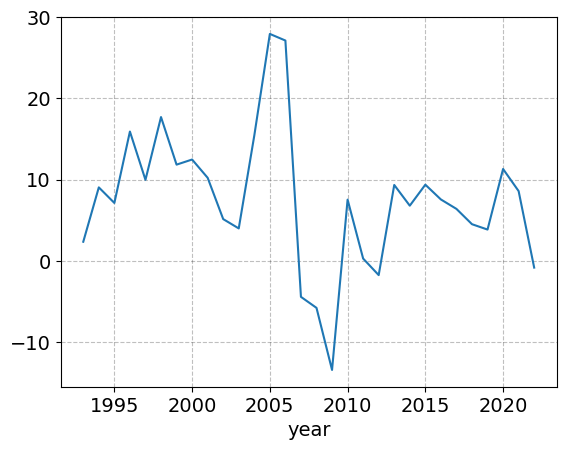

In [64]:
# We plot the Growth rate in house prices in copenhagen
house_københavn2.plot(x='year', y='Growth_Rate', legend=False );

In [81]:
# We calculate the growrate and the geometric mean in appartment prices in Copenhagen
ap_københavn['Growth_Rate'] = ap_københavn['ap'].pct_change(periods=1) * 100
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())
gm2 = g_mean(ap_københavn2['Growth_Rate'])
print ("%.2f" % gm2)
ap_københavn['Gmean'] = gm2
ap_københavn['D_Gmean'] = ap_københavn.Growth_Rate - ap_københavn.Gmean
ap_københavn.head(10)

9.97


/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/ipykernel_24807/3181532208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_københavn['Growth_Rate'] = ap_københavn['ap'].pct_change(periods=1) * 100
/Users/joakimhagerupjensen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/pz/kctcbrz913q45c9l_2mncn_r0000gp/T/ipykernel_24807/3181532208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,County,year,ap,Growth_Rate,Gmean,D_Gmean
0,Landsdel Byen København,1992,421,NaN,9.970975,NaN
11,Landsdel Byen København,1993,417,-0.950119,9.970975,-10.921093
22,Landsdel Byen København,1994,453,8.633094,9.970975,-1.337881
33,Landsdel Byen København,1995,475,4.856512,9.970975,-5.114462
44,Landsdel Byen København,1996,510,7.368421,9.970975,-2.602554
55,Landsdel Byen København,1997,529,3.725490,9.970975,-6.245484
66,Landsdel Byen København,1998,668,26.275992,9.970975,16.305018
77,Landsdel Byen København,1999,808,20.958084,9.970975,10.987109
88,Landsdel Byen København,2000,929,14.975248,9.970975,5.004273
99,Landsdel Byen København,2001,1100,18.406889,9.970975,8.435915


In [82]:
# We drop the NaN value from the dataset 
ap_københavn2 = ap_københavn.dropna()
ap_københavn2['Growth_Rate'].round(2)
ap_københavn2.head(10)

,County,year,ap,Growth_Rate,Gmean,D_Gmean
11,Landsdel Byen København,1993,417,-0.950119,9.970975,-10.921093
22,Landsdel Byen København,1994,453,8.633094,9.970975,-1.337881
33,Landsdel Byen København,1995,475,4.856512,9.970975,-5.114462
44,Landsdel Byen København,1996,510,7.368421,9.970975,-2.602554
55,Landsdel Byen København,1997,529,3.725490,9.970975,-6.245484
66,Landsdel Byen København,1998,668,26.275992,9.970975,16.305018
77,Landsdel Byen København,1999,808,20.958084,9.970975,10.987109
88,Landsdel Byen København,2000,929,14.975248,9.970975,5.004273
99,Landsdel Byen København,2001,1100,18.406889,9.970975,8.435915
110,Landsdel Byen København,2002,1213,10.272727,9.970975,0.301753


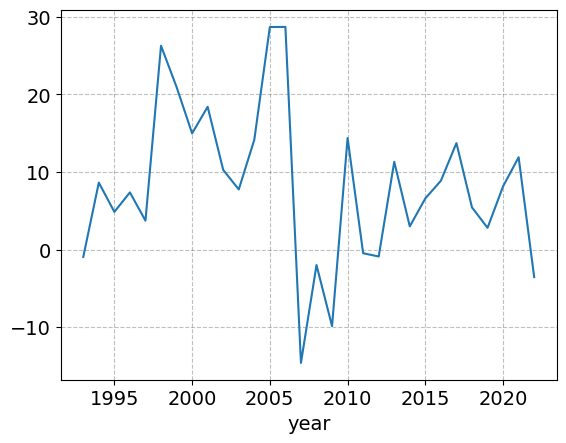

In [68]:
# We plot the Growth rate in appartment prices in Copenhagen
ap_københavn2.plot(x='year', y='Growth_Rate', legend=False );

# Conclusion

ADD CONCISE CONLUSION.